# Step counter tutorial

This is a simple tutorial outlining the implementation of hybrid step count model produced by the OxWearables group.
A more comprehensive detailing of this model can be found in Small et al. (2023)[[1]](https://www.medrxiv.org/content/10.1101/2023.02.20.23285750v1).

The hybrid step count model consists of a peak detector, tuned to detect steps, and a walking detector, tuned to identify walking. 
The model is trained on data collected by Dr. Small as part of the OxWearables group, of 1 hour of annotated steps, with accelerometery recorded from the non dominant wrist at 100Hz.

In [1]:
# ------------------------------------------------------------
# Import necessary packages
# ------------------------------------------------------------

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import os
import re
from glob import glob
import numpy as np
import pandas as pd
from scipy import signal
from sklearn import metrics
import shutil
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import urllib.request
import zipfile

import stepcount.features as features
import stepcount.hmm_utils as hmm_utils
import stepcount.models as models

In [2]:
# ------------------------------------------------------------
# Download the OxWalk dataset
# ------------------------------------------------------------

print(f"Downloading OxWalk...")
url = "https://ora.ox.ac.uk/objects/uuid:19d3cb34-e2b3-4177-91b6-1bad0e0163e7/files/dcj82k7829"
with urllib.request.urlopen(url) as f_src, open("OxWalk_Dec2022.zip", "wb") as f_dst:
    shutil.copyfileobj(f_src, f_dst)
print("Unzipping...")
with zipfile.ZipFile("OxWalk_Dec2022.zip", "r") as f:
    f.extractall(".")

Unzipping...


## Setup

In [3]:
oxwalk_dir = 'OxWalk_Dec2022/Wrist_100Hz/'
SAMPLE_RATE = 100  # Hz
WINDOW_SEC = 10  # seconds
STEPTOL = 4  # count
WINDOW_LEN = int(WINDOW_SEC * SAMPLE_RATE)  # ticks

In [4]:
# --------------------------
#   Some utility functions
# --------------------------

def read_csv(filename):
    """ Data loader """

    data = pd.read_csv(
        filename, 
        parse_dates=['timestamp'], 
        index_col='timestamp',
        dtype={
            'x': 'f4', 
            'y': 'f4', 
            'z': 'f4', 
            'annotation': 'Int64',
        }
    )
    return data


def plotw(w, ax, lp=None, find_peaks=False, find_peaks_params=None):
    """ Plot a window accel trace """

    v = np.linalg.norm(w[['x', 'y', 'z']].to_numpy(), axis=1)  # absolute accel magnitude
    v = v - 1  # detrend: "remove gravity"

    if lp:
        # lowpass filter
        v = features.butterfilt(v, lp, SAMPLE_RATE)

    xanno = np.argwhere(w['annotation'].to_numpy()).ravel()
    yanno = v[xanno]
    ax.plot(v)
    ax.scatter(xanno, yanno, marker='x', c='k', label='step')
    title = f"steps: {len(xanno)}"

    if find_peaks:
        find_peaks_params = find_peaks_params or {}
        peaks, _ = signal.find_peaks(v, **find_peaks_params)
        ax.scatter(peaks, v[peaks], marker='o', fc='none', ec='r', label='find_peaks')
        title = f"{title} | find_peaks: {len(peaks)}"

    ax.grid(True)
    ax.legend()
    ax.set_title(title)
    return ax


def plotsome(data, **kwargs):
    """ Plot some windows """

    NFIGS_WALK = 10  # walk windows to plot
    NFIGS_NOTWALK = 5  # non-walk windows to plot
    NFIGS = NFIGS_WALK + NFIGS_NOTWALK
    NROWS = 3
    NCOLS = NFIGS // NROWS
    FIGSIZE = (4 * NCOLS, 3 * NROWS)

    fig, axs = plt.subplots(ncols=NCOLS, nrows=NROWS, figsize=FIGSIZE)

    n = 0
    for _, w in data.resample(f"{WINDOW_SEC}s"):
        if w['annotation'].sum() >= STEPTOL:
            plotw(w, axs.flat[n], **kwargs)
            n += 1
        if n >= NFIGS_WALK: break

    m = 0
    for _, w in data.resample(f"{WINDOW_SEC}s"):
        if w['annotation'].sum() < STEPTOL:
            plotw(w, axs.flat[n + m], **kwargs)
            m += 1
        if m >= NFIGS_NOTWALK: break

    return fig


## Visuals

Always good idea to visualize the data.

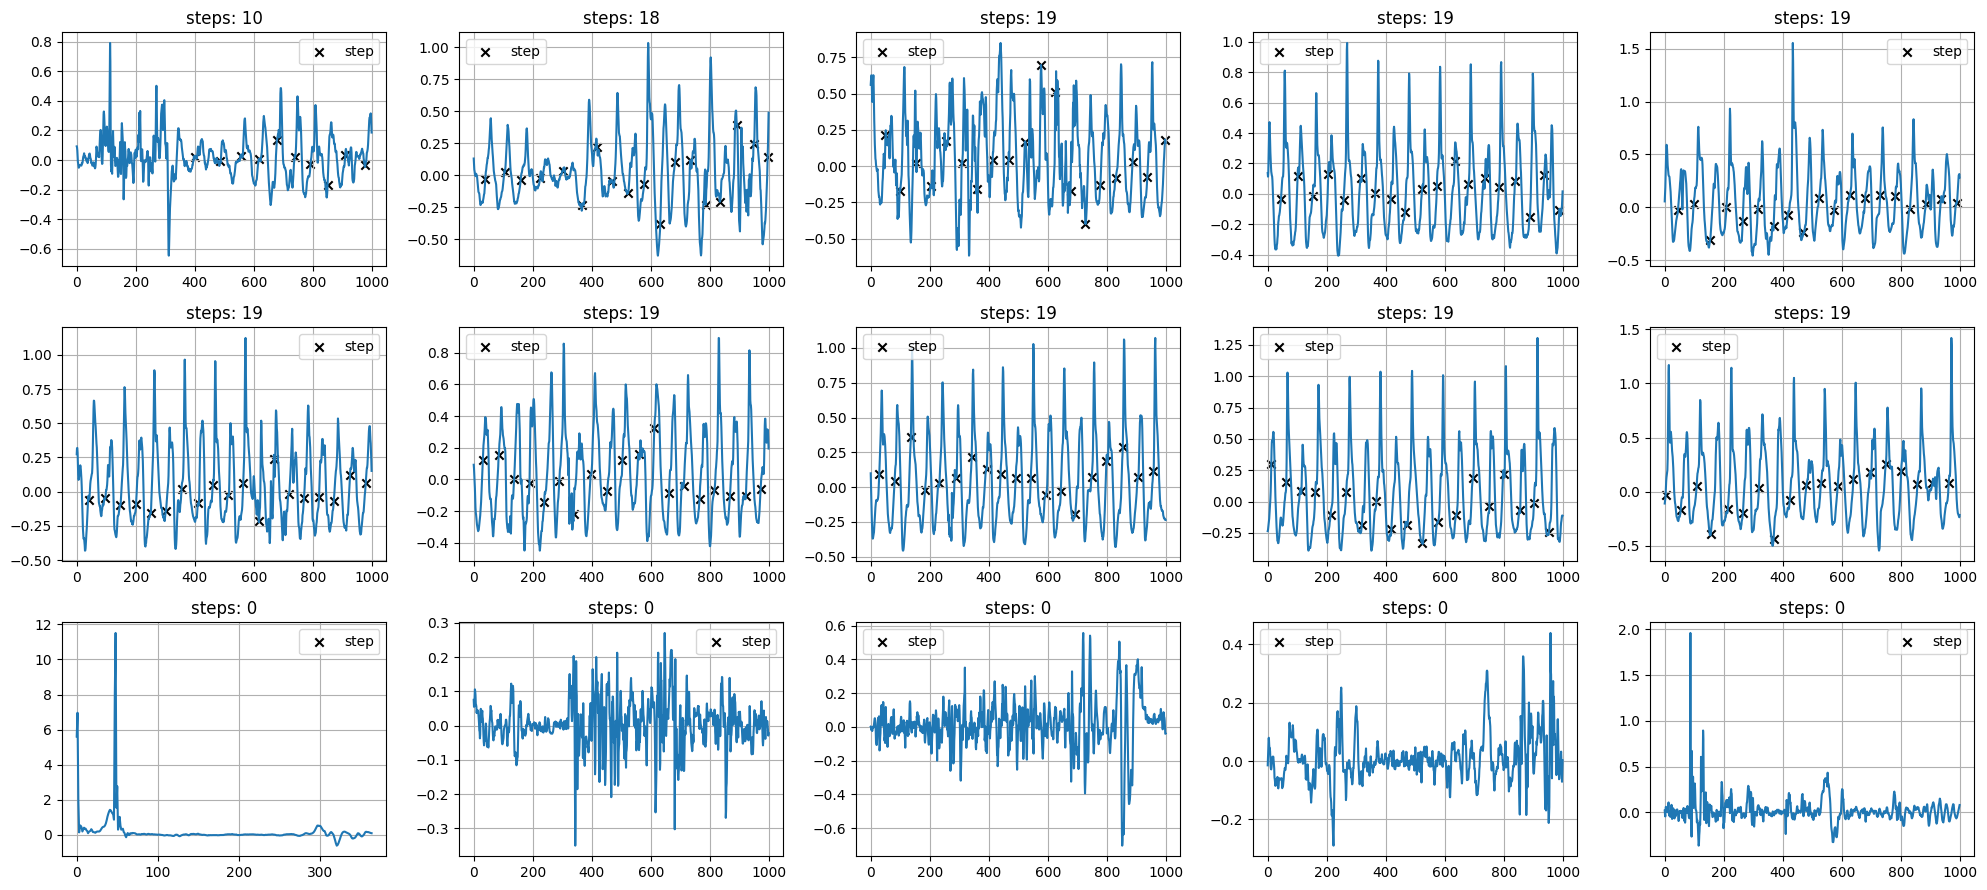

In [5]:
data = read_csv(oxwalk_dir+"P01_wrist100.csv")

fig = plotsome(data)
fig.tight_layout()

The top two rows in these plots are indicitive of times of walking, while the bottom row includes epochs of defined non-walking.
In the setup, we've defined walking as at least 4 annotated steps in a 10 second window.
How do the plots change when we change our definition of walking (ie. change the number of steps per 10 second epoch required to be classified as walking)?

## Step counts

To infer steps from accelerometry, we assume that steps correspond to peaks in acceleration.
This is reasonable: You might recall that conundrum in highschool physics about
instantaneaous collisions resulting in infinite forces.

We will use the peak finding algorithm implemented in `scipy.find_peaks`. 

Let's visualize the traces again, this time enabling peak finding.

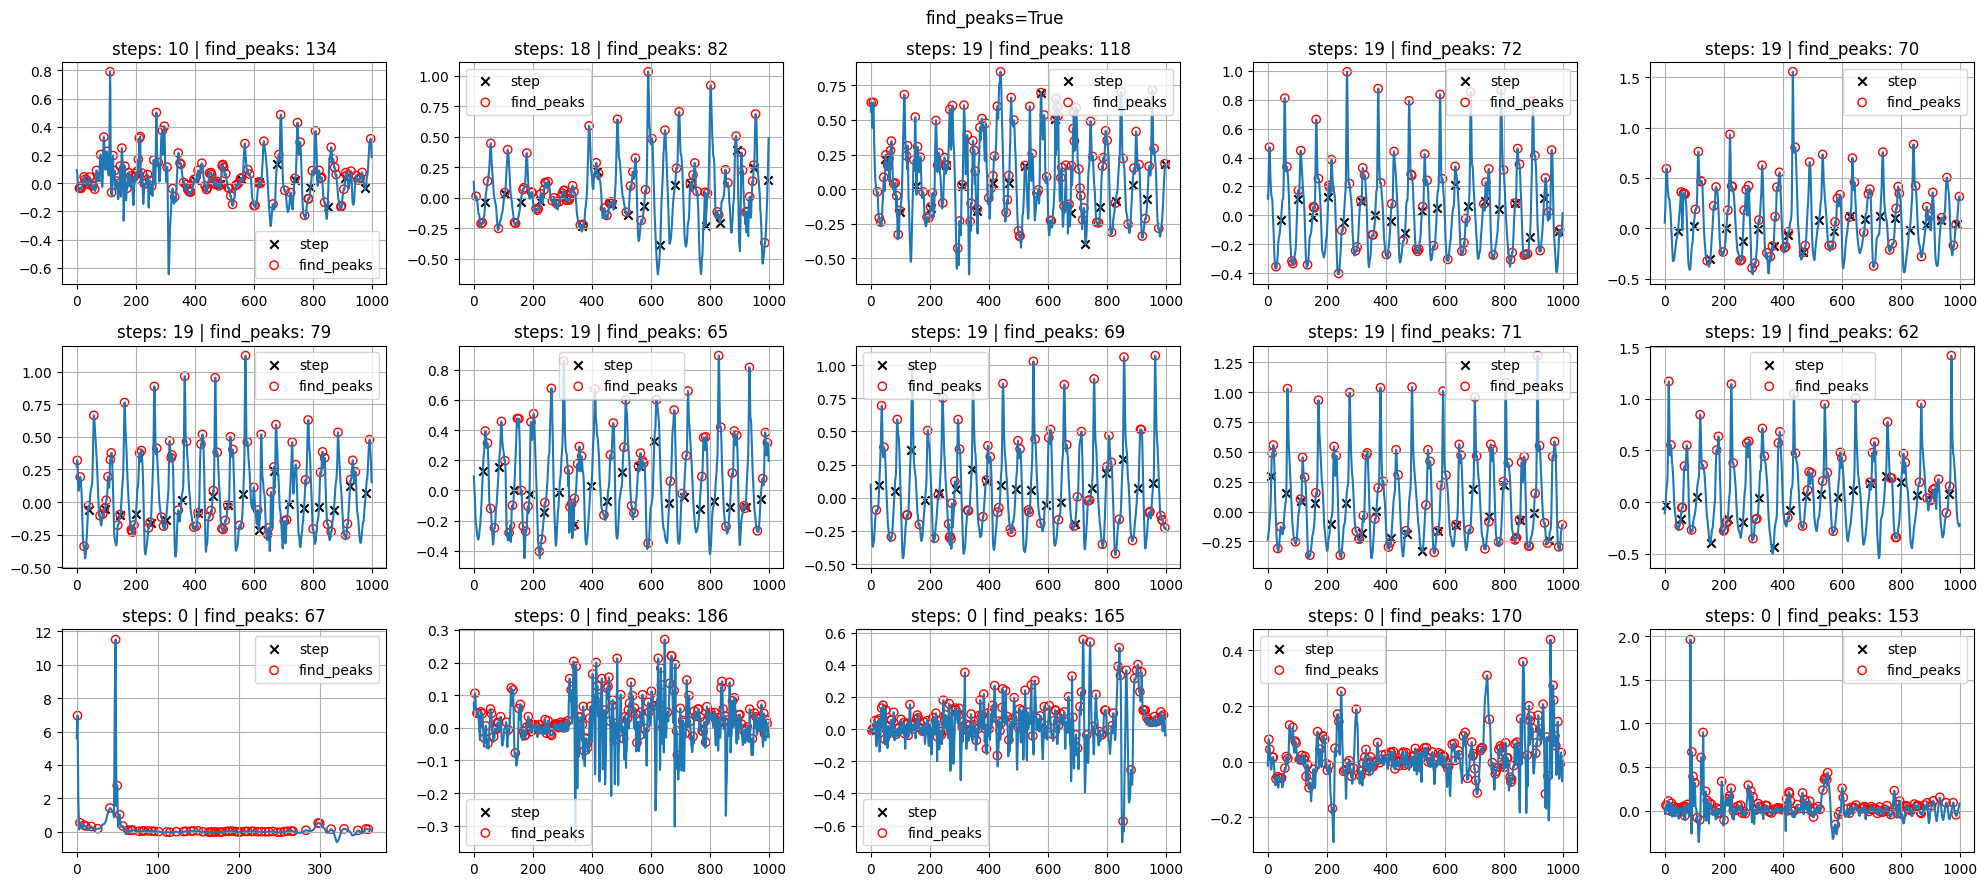

In [6]:
fig = plotsome(data, find_peaks=True)
fig.suptitle("find_peaks=True")
fig.tight_layout()

Peak finding with default parameters finds every single peak present in the signal, which is not really what we want.

We can tune the peak finder to only consider peaks that satisfy certain
conditions. Two parameters that we can tune are the minimum `distance` between
peaks and the minimum `prominence` of the peaks. The higher these values, the
stricter the peak selection becomes.

After eyeballing the plots, let's try values 0.1 for `prominence` and 0.2 sec for `distance`.


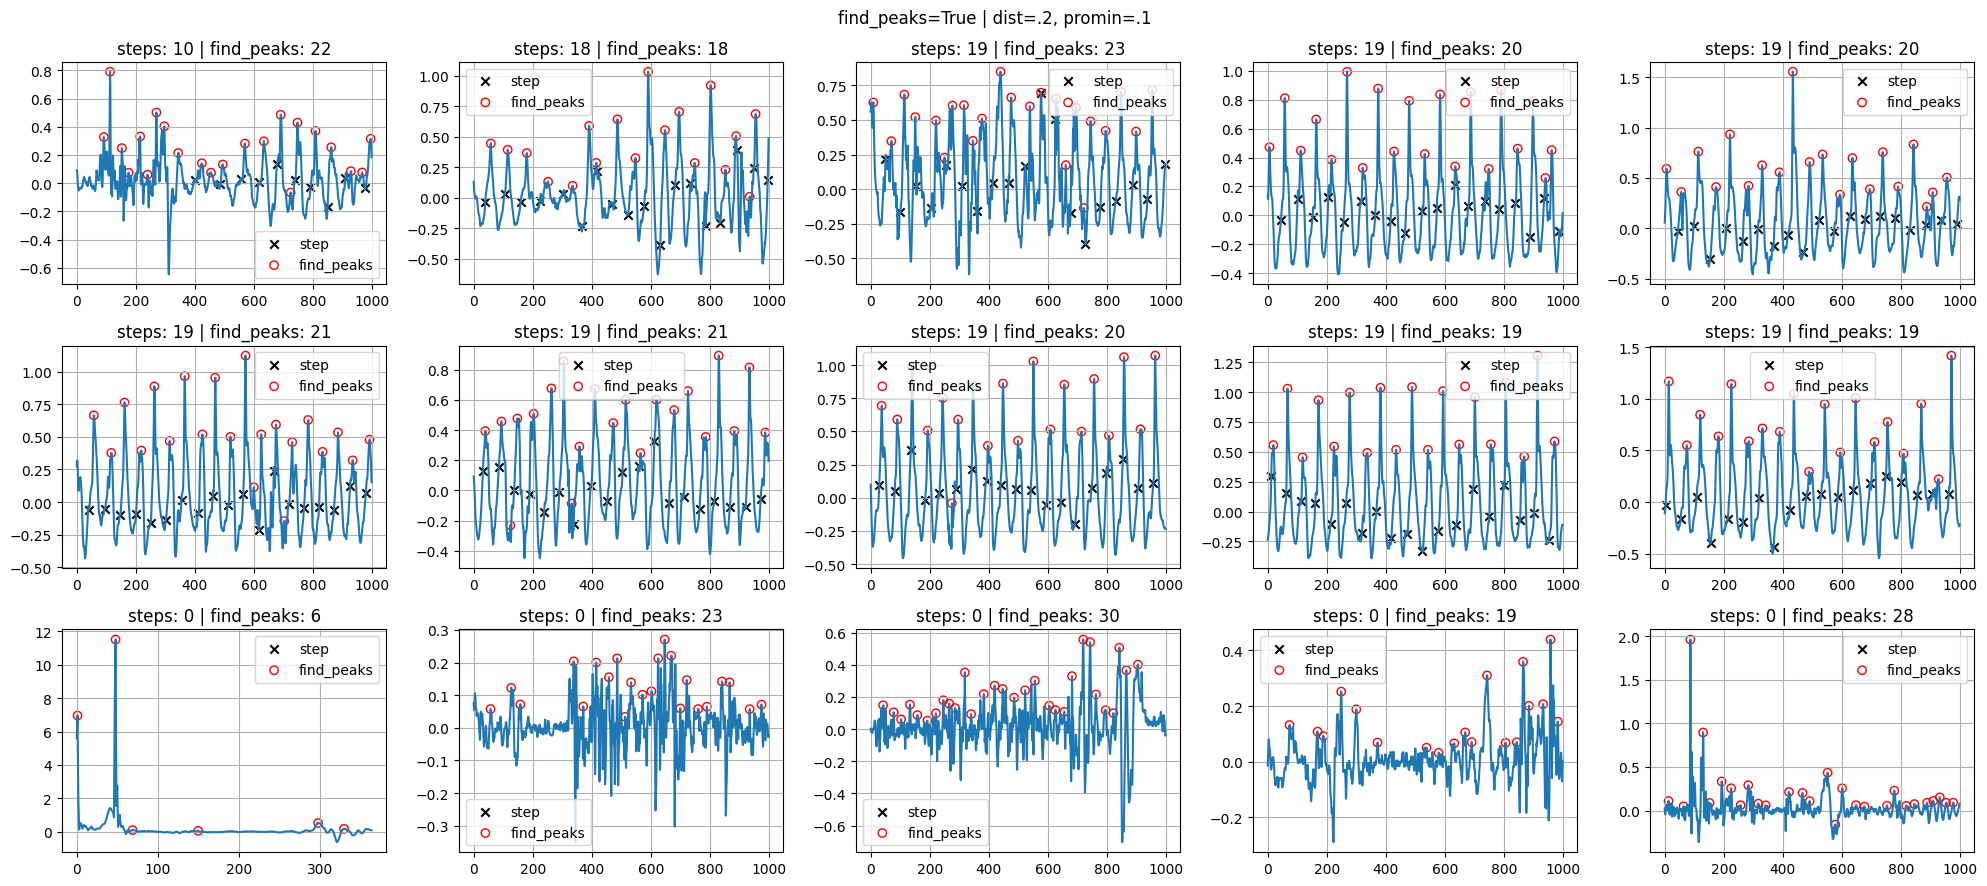

In [7]:
fig = plotsome(
    data, 
    find_peaks=True,
    find_peaks_params={
        'distance': .2 * SAMPLE_RATE,  # 0.2s in ticks
        'prominence': .1
    }
)
fig.suptitle("find_peaks=True | dist=.2, promin=.1")
fig.tight_layout()

We get big improvements after tuning the peak finder.

A common signal processing technique is to filter out frequencies that are irrelevant for the task.
In activity recognition, a lowpass filter with 3Hz cutoff is commonly applied for walk analysis.

Let's apply a 5Hz lowpass filter. We use a looser cutoff as we might also want to capture running steps, for which 5Hz is a reasonable upper bound. 
For example, Usain Bolt's sprint frequency is around 4.3Hz: https://www.econathletes.com/post/math-for-sprinters-steps-per-second-and-stride-length.

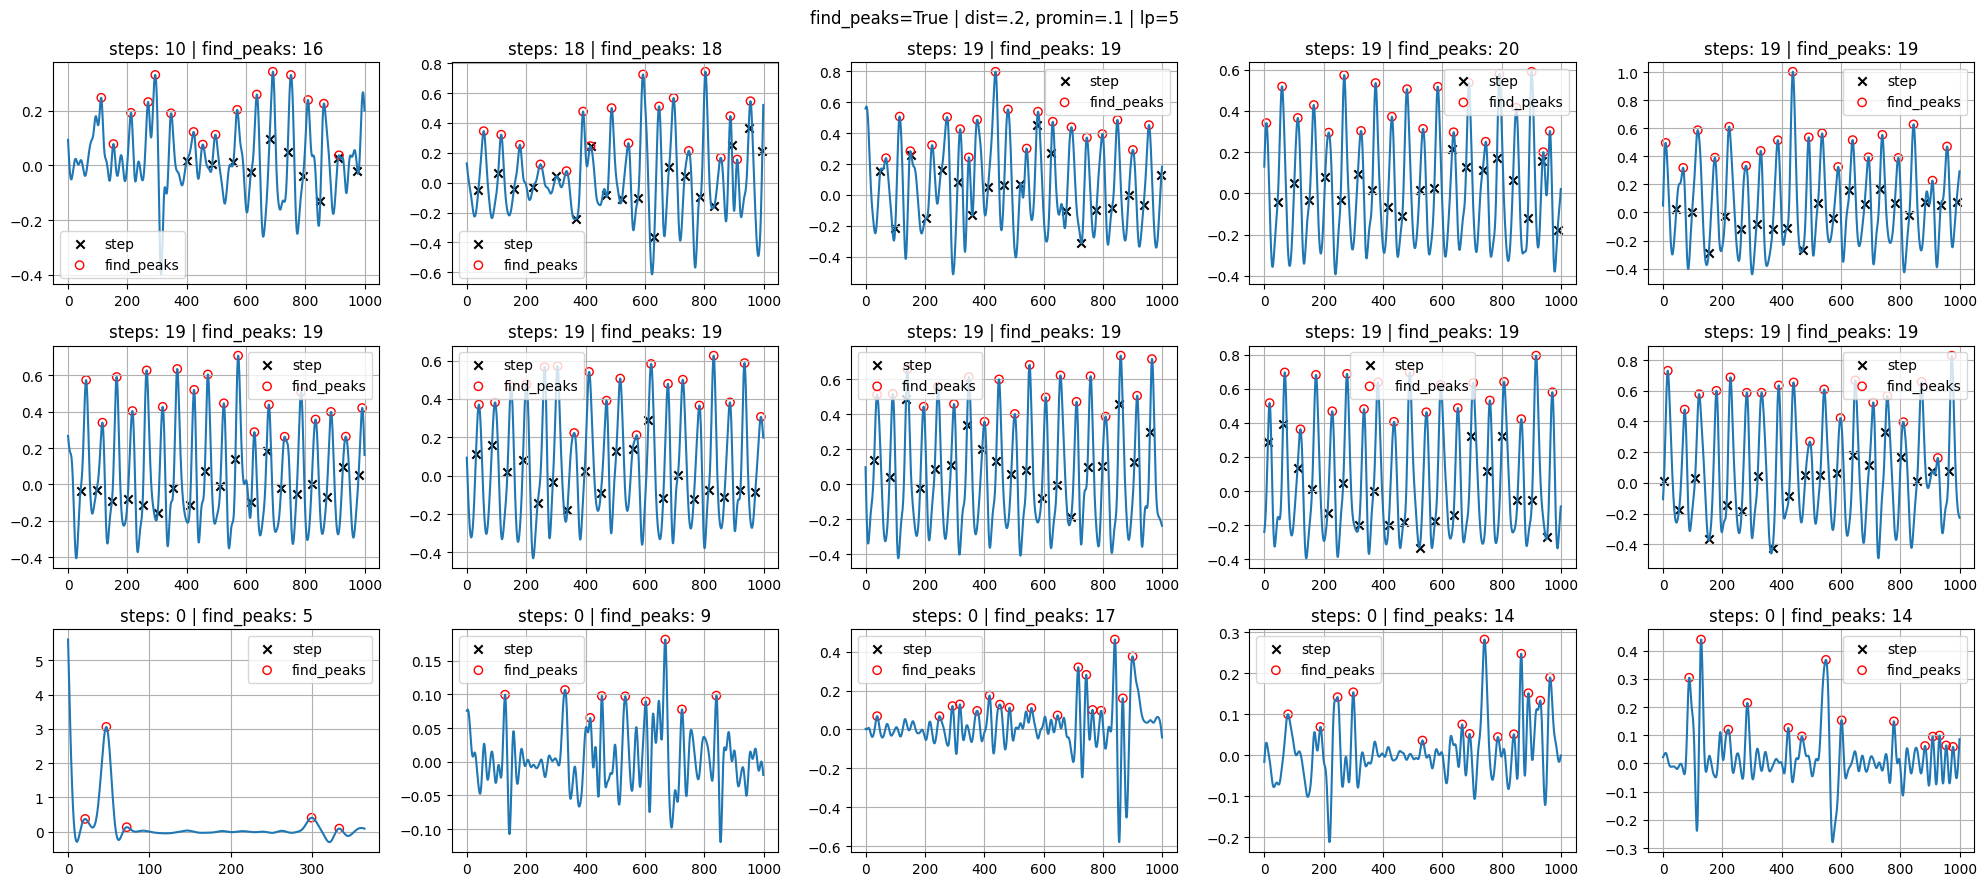

In [8]:
fig = plotsome(
    data, 
    find_peaks=True,
    find_peaks_params={
        'distance': .2 * SAMPLE_RATE,  # 0.2s in ticks
        'prominence': .1
    },
    lp=5,  # 5Hz lowpass filter
)
fig.suptitle("find_peaks=True | dist=.2, promin=.1 | lp=5")
fig.tight_layout()

The filter clears out the signal making it easier to find relevant peaks. It helps most in reducing false positives, especially when high frequencies are present.

While peak finding performs well for walk windows (first two rows), it tends to give false positives in non-walk windows (last row). This motivates us to build a _walk detection model_ to further filter only the walk segments.

## Walk detection model

After splitting the data into 10 sec windows, we extract features commonly used in the activity recognition literature. We then train a random forest to classify each window as either walk or non-walk. Finally, a hidden Markov model is applied to "glue" together the model outputs in a smooth manner.

Note that the model used in Small et al. (2023) [[1]]((https://www.medrxiv.org/content/10.1101/2023.02.20.23285750v1)) was instead a ResNet18, however we demonstrate a random forest in this tutorial. It would be possible to exchange the walking detection model with any supervised learning model, with various benefits and pitfalls.

### Feature extraction

In [9]:
def make_windows(data, window_sec=WINDOW_SEC, sample_rate=SAMPLE_RATE):
    """ Split data into windows, extract features and assign labels """

    X_raw = []
    X_feats = []

    window_len = int(window_sec * sample_rate)

    for i, w in data.resample(f"{window_sec}s"):

        if len(w) < window_len:
            continue
        
        if w.isna().any().any():
            continue

        steps = w['annotation'].sum()
        is_walk = int(steps >= STEPTOL)
        #steps *= is_walk  # only count if it's a walk window
        xyz = w[['x', 'y', 'z']].to_numpy()

        X_raw.append(xyz)

        X_feats.append({
            'time': w.index[0],
            **features.extract_features(xyz, sample_rate),
            'steps': steps,
            'is_walk': is_walk,
        })

    X_raw = np.stack(X_raw)
    X_feats = pd.DataFrame(X_feats)

    return X_raw, X_feats

In [10]:
X = []
feats = []

for filename in tqdm(glob(oxwalk_dir+"*.csv")):

    data = read_csv(filename)
    _X_raw, _X_feats = make_windows(data)
    pid = re.search(r'(P\d{2})', os.path.basename(filename)).group(1).upper()  # P01, P02, ...
    _X_feats['pid'] = pid

    X.append(_X_raw)
    feats.append(_X_feats)

X = np.concatenate(X)
feats = pd.concat(feats)

display(feats)
print("X shape:", X.shape)

# Save for future use
np.save("X.npy", X)
feats.to_pickle("feats.pkl")

  0%|          | 0/39 [00:00<?, ?it/s]

,time,avg,std,skew,kurt,min,q25,med,q75,max,...,fft3,fft4,fft5,npeaks,peaks_avg_promin,peaks_min_promin,peaks_max_promin,steps,is_walk,pid
0,2019-07-22 14:43:00,0.005833,0.059856,0.151146,1.919423,-0.219524,-0.023226,0.002158,0.033220,0.230379,...,0.000303,0.000252,0.000134,0.1,0.287316,0.287316,0.287316,0,0,P01
1,2019-07-22 14:43:10,0.015456,0.135104,-0.483128,4.434363,-0.619267,-0.041838,0.013916,0.068123,0.486034,...,0.001069,0.000543,0.000936,0.6,0.474965,0.291522,0.694381,0,0,P01
2,2019-07-22 14:43:20,0.010346,0.077556,0.984750,3.021571,-0.256446,-0.028009,0.000849,0.038100,0.333157,...,0.000422,0.000237,0.000144,0.3,0.332148,0.255467,0.418119,0,0,P01
3,2019-07-22 14:43:30,0.018054,0.099643,1.062083,4.958935,-0.321964,-0.028290,0.007316,0.047822,0.572276,...,0.000774,0.000779,0.000341,0.4,0.389010,0.265496,0.597515,0,0,P01
4,2019-07-22 14:43:40,0.021107,0.135440,0.162649,1.822787,-0.579907,-0.050377,0.013357,0.079367,0.489216,...,0.001326,0.001074,0.000234,0.9,0.420505,0.255504,0.587916,10,1,P01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,2019-07-22 14:32:00,0.259698,0.328492,0.324160,-0.402031,-0.442068,0.027291,0.219882,0.487931,1.212949,...,0.011960,0.005291,0.001700,2.1,0.652260,0.250371,1.269182,0,0,P39
355,2019-07-22 14:32:10,0.069484,0.287733,1.430873,7.218758,-0.779771,-0.092171,0.050592,0.196508,1.797870,...,0.010749,0.005243,0.002503,1.8,0.627348,0.276373,2.006967,0,0,P39
356,2019-07-22 14:32:20,0.039822,0.210929,0.393895,0.454529,-0.423266,-0.048063,0.009706,0.143334,0.724676,...,0.002761,0.001851,0.001060,1.0,0.585247,0.320144,0.903784,0,0,P39
357,2019-07-22 14:32:30,0.005701,0.025574,-1.277892,8.633292,-0.151217,-0.000731,0.005898,0.014656,0.098264,...,0.000033,0.000024,0.000011,0.0,0.000000,0.000000,0.000000,0,0,P39


X shape: (13600, 1000, 3)


### Random forest for walk detection

In [11]:
X = np.load('X.npy')
feats = pd.read_pickle('feats.pkl')

# Train/Test split

np.random.seed(123)  # for reproducibility

test_pids = np.random.choice(feats['pid'].unique(), size=10, replace=False)
feats_test = feats[feats['pid'].isin(test_pids)]
feats_train = feats[~feats['pid'].isin(test_pids)]

print("Test PIDs:", test_pids)
print("Train frame shape:", feats_train.shape)
print("Test frame shape:", feats_test.shape)

Test PIDs: ['P07' 'P11' 'P13' 'P38' 'P06' 'P12' 'P24' 'P02' 'P14' 'P21']
Train frame shape: (10159, 36)
Test frame shape: (3441, 36)


In [12]:
not_feats_cols = ['time', 'pid', 'is_walk', 'steps']

X_train = feats_train.drop(columns=not_feats_cols).to_numpy()
Y_train = feats_train['is_walk'].to_numpy()
pid_train = feats_train['pid'].to_numpy()

clf = BalancedRandomForestClassifier(
    n_estimators=1000,
    replacement=True,
    sampling_strategy='not minority',
    oob_score=True,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
clf.fit(X_train, Y_train)

X_test = feats_test.drop(columns=not_feats_cols).to_numpy()
Y_test = feats_test['is_walk'].to_numpy()
pid_test = feats_test['pid'].to_numpy()

Y_test_pred = clf.predict(X_test)

print(metrics.classification_report(Y_test, Y_test_pred))
print("Per participant F1 score: {}".format(np.mean([metrics.f1_score(Y_test[pid_test==pid], 
                                                                      Y_test_pred[pid_test==pid]) 
                                                     for pid in np.unique(pid_test)])))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1695
           1       0.85      0.96      0.90      1746

    accuracy                           0.89      3441
   macro avg       0.90      0.89      0.89      3441
weighted avg       0.90      0.89      0.89      3441

Per participant F1 score: 0.8624501343751643


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


For computational efficiency you may sometimes need to adjust the number of estimators in the model. 
How does changing the number of estimators affect model performance?

The random forest classifier we are using is a balanced classifier, meaning that it assumes there should be a roughly even distribution between the walk and non-walk classes. 
Look through the data, is this true in our training data? Is this true in free-living? 
What are the implications of using a balanced classifier for walking detection trained in this data?

If you have time, looking at the [documentation for the balanced random forest](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html), how might you address this issue of balance?

### Hidden Markov model

The random forest classifies each window independently and doesn't account for
temporal dependencies, so we further apply a HMM to smooth the outputs.

In [13]:
hmms = hmm_utils.HMMSmoother().fit(clf.oob_decision_function_, Y_train, pid_train)
Y_test_pred_hmm = hmms.predict(Y_test_pred, pid_test)
print(metrics.classification_report(Y_test, Y_test_pred_hmm))
print("Per participant F1 score: {}".format(np.mean([metrics.f1_score(Y_test[pid_test==pid], 
                                                                      Y_test_pred_hmm[pid_test==pid]) 
                                                     for pid in np.unique(pid_test)])))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1695
           1       0.85      0.95      0.90      1746

    accuracy                           0.89      3441
   macro avg       0.90      0.89      0.89      3441
weighted avg       0.90      0.89      0.89      3441

Per participant F1 score: 0.8635087025395176


## End-to-end model training and testing

Combining these concepts together, we can train a single step counter model that will fit both the peak detector, and the walking detector.

In [14]:
# First, split into training and test
test_pids = np.random.choice(feats['pid'].unique(), size=10, replace=False)

X_raw_train = X[~feats['pid'].isin(test_pids)]
X_raw_test = X[feats['pid'].isin(test_pids)]
Y_train = feats.loc[~feats['pid'].isin(test_pids), 'steps'].to_numpy()
Y_test = feats.loc[feats['pid'].isin(test_pids), 'steps'].to_numpy()
pid_train = feats.loc[~feats['pid'].isin(test_pids), 'pid'].to_numpy()
pid_test = feats.loc[feats['pid'].isin(test_pids), 'pid'].to_numpy()

In [15]:
# Use step counter model to train end-to-end
# Note: this can take a long time
stepCounter = models.StepCounter(wd_type='rf', cv=4, window_sec=WINDOW_SEC,
                                 sample_rate=SAMPLE_RATE, steptol=STEPTOL,
                                 verbose=True)
stepCounter.fit(X_raw_train, Y_train, pid_train)

# View trained parameters:
print("Tuned peak parameters: {}".format(stepCounter.find_peaks_params))

Running cross_val_predict...
Fitting walk detector...
Tuning step counter...
Tuned peak parameters: {'distance': 0.23556365966796894, 'prominence': 0.21256217956542747}


Note that you can also view other trained parameters:
* Walk detection training performance: `stepCounter.cv_results["walk_detector"]["scores"]`
* Step count training performance: `stepCounter.cv_results["step_counter"]["scores"]`

Evaluate the step counter on the test population

In [16]:
test_step_pred = []
test_step_true = []

for pid in np.unique(pid_test):
    X_p = X_raw_test[pid_test == pid]
    Y_p = Y_test[pid_test == pid]
    
    test_step_true.append(sum(Y_p))
    test_step_pred.append(sum(stepCounter.predict(X_p, Y_p)))

Often, step count performance is evaluated using the [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error).
Existing literature surrounding the use of wrist-worn accelerometers requires a step count algorithm to have a MAPE <10% to be considered valid [[1]](https://journals.lww.com/acsm-msse/Fulltext/2018/03000/Validity_of_Wearable_Activity_Monitors_during.28.aspx). 
This requirement is generally only tested on data collected in controlled environments, on a healthy population. 
Investigation into many commercial devices show the MAPE to sit around this value, under the previously listed conditions [[2]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6743766/#pone.0222569.ref036).
For this dataset however, we monitor participants during free living, in which walking behaviour is far less typical.

We calculate the MAPE for the test population below:

In [17]:
print("Mean absolute percentage error: {:.2f}%".format(
    100*metrics.mean_absolute_percentage_error(test_step_true, test_step_pred)))

Mean absolute percentage error: 52.91%


In addition, it common to generate a bland altman plot, to visualise how the predicted step count deviates from the true step count. 
Through this, we can visualise biases in our model, and compare to other step count models.

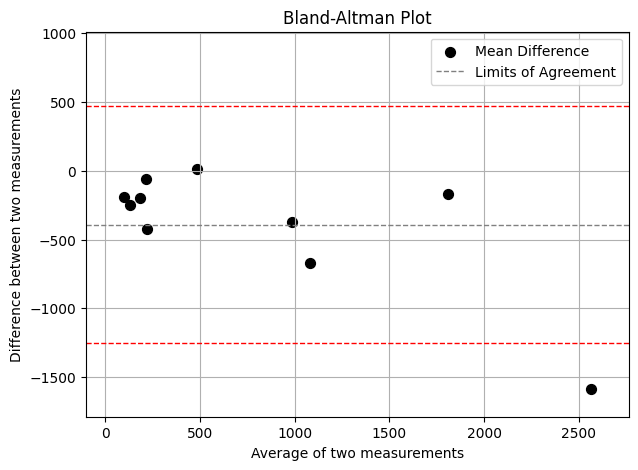

In [18]:
# Calculate the difference and the average of the two measurements
diff = np.array(test_step_pred) - np.array(test_step_true)
mean = np.mean([test_step_pred, test_step_true], axis=0)

# Define the limits of agreement as +/- 1.96 times the standard deviation of the differences
lim_agree = 1.96 * np.std(diff)

# Create the Bland-Altman plot
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(mean, diff, color='black', s=50)
ax.axhline(np.mean(diff), color='gray', linestyle='--', linewidth=1)
ax.axhline(np.mean(diff) + lim_agree, color='red', linestyle='--', linewidth=1)
ax.axhline(np.mean(diff) - lim_agree, color='red', linestyle='--', linewidth=1)

# Set axis labels and title
ax.set_xlabel('Average of two measurements')
ax.set_ylabel('Difference between two measurements')
ax.set_title('Bland-Altman Plot')

# Set the x and y axis limits
ax.set_xlim([np.min(mean) - 200, np.max(mean) + 200])
ax.set_ylim([np.min(diff) - 200, np.max(diff) + 1000])

# Add gridlines
ax.grid(True)

# Add a legend
ax.legend(['Mean Difference', 'Limits of Agreement'], loc='upper right')

What other metric could be used to measure the performance of a step counting algorithm? 
When you implement that below, does it agree with the MAPE performance?

## References

1. [https://www.medrxiv.org/content/10.1101/2023.02.20.23285750v1](https://www.medrxiv.org/content/10.1101/2023.02.20.23285750v1)
2. [https://journals.lww.com/acsm-msse/Fulltext/2018/03000/Validity_of_Wearable_Activity_Monitors_during.28.aspx)](https://journals.lww.com/acsm-msse/Fulltext/2018/03000/Validity_of_Wearable_Activity_Monitors_during.28.aspx). 
3. [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6743766/#pone.0222569.ref036](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6743766/#pone.0222569.ref036).